In [1]:
import albumentations
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import os

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import timm

from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

### Pick cropped dataset

In [3]:
class config:
    root_path = '/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg'
    train_path = root_path + '/train'
    test_path = root_path + '/test'
    valid_path = root_path + '/validation'
    output_path = "/kaggle/working/"
    batch_size = 16
    lr = 1e-3
    seed = 1
    num_epochs = 40
    model_names = 'swin_base_patch4_window7_224.ms_in1k'
    
config.root_path

'/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg'

In [4]:
config.train_path

'/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512-jpg/train'

In [5]:
def get_df(path): 
    paths = Path(path).rglob("*.jpg")
    files = [str(path) for path in paths]
    labels = [file.split('/')[-2] for file in files]
    
    df = pd.DataFrame()
    df['path'] = files
    df['label'] = labels
    df['label'] = df['label'].map({'RG':1, 'NRG': 0})
    return df

# Assuming CFG.path_to_data is set to the correct data path, the following lines will create your dataframes:
train_df = get_df(config.train_path)
valid_df = get_df(config.valid_path)
test_df = get_df(config.test_path)

In [6]:
train_df

,path,label
0,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,1
1,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,1
2,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,1
3,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,1
4,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,1
...,...,...
7995,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,0
7996,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,0
7997,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,0
7998,/kaggle/input/glaucoma-dataset-eyepacs-airogs-...,0


In [7]:
from PIL import Image
import os
import torch
from sklearn.model_selection import train_test_split

    
# define a data class
class ClassificationDataset:
    def __init__(self, data, data_path, transform, training=True):
        """Define the dataset for classification problems

        Args:
            data ([dataframe]): [a dataframe that contain 2 columns: image name and label]
            data_path ([str]): [path/to/folder that contains image file]
            transform : [augmentation methods and transformation of images]
            training (bool, optional): []. Defaults to True.
        """
        self.data = data
        self.imgs = data["path"].unique().tolist()
        self.data_path = data_path
        self.training = training
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.data_path, self.data.iloc[idx, 0]))
        if(self.training):
            label = self.data.iloc[idx, 1]
        if self.transform is not None:
            img = self.transform(img)
        if(self.training):
            return img, label
        else:
            return img

    def __len__(self):
        return len(self.imgs)


def make_loader(dataset, train_batch_size, validation_split=0.2):
    """make dataloader for pytorch training

    Args:
        dataset ([object]): [the dataset object]
        train_batch_size ([int]): [training batch size]
        validation_split (float, optional): [validation ratio]. Defaults to 0.2.

    Returns:
        [type]: [description]
    """
    # number of samples in train and test set
    train_len = int(len(dataset) * (1 - validation_split))
    test_len = len(dataset) - train_len
    train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
    # create train_loader
    print(len(train_set))
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=train_batch_size, shuffle=True,
    )
    # create test_loader
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False,)
    return train_loader, test_loader


def data_split(data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        data, data["label"], test_size=test_size, stratify = data.iloc[:,1]
    )
    return x_train, x_test, y_train, y_test

# 1. Define DataLoader

In [8]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

In [9]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)])

In [10]:
test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)])

In [11]:
dataset = ClassificationDataset(train_df,data_path = "",transform=transform,training=True)
train_loader,val_loader = make_loader(dataset, train_batch_size=config.batch_size, validation_split=0.2)

6400


In [12]:
import random

# Generate a random integer between 0 and 2^32 - 1
random_seed = random.randint(0, 128)
print("Random seed: ",random_seed)

Random seed:  57


In [13]:
 X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['label'],stratify=train_df['label'], test_size=0.2, random_state=random_seed)

In [14]:
train_dataset = ClassificationDataset(X_train,data_path = "",transform=transform,training=True)
val_dataset = ClassificationDataset(X_test,data_path = "",transform=test_transform,training=True)

In [15]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True,
    )
    # create test_loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

In [16]:
testset = ClassificationDataset(test_df,data_path = "",transform=test_transform,training=False)
test_loader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=False,
    )

In [17]:
from tqdm import tqdm
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(test_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

count = len(test_df) * 224 * 224

# mean and std
test_mean = psum / count
test_var  = (psum_sq / count) - (test_mean ** 2)
test_std  = torch.sqrt(test_var)

100%|██████████| 770/770 [00:08<00:00, 87.53it/s]


In [18]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs,_ in tqdm(train_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

count = len(train_loader) * 224 * 224

# mean and std
train_mean = psum / count
train_var  = (psum_sq / count) - (train_mean ** 2)
train_std  = torch.sqrt(train_var)

100%|██████████| 400/400 [01:14<00:00,  5.34it/s]


In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.pause(0.001)

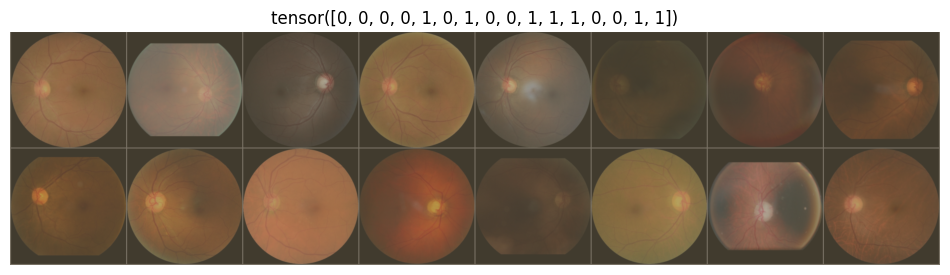

In [20]:
import matplotlib.pyplot as plt

%matplotlib inline
# Visualization
images, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out, title=classes)

# 2. Define Metrics and Optimizers and Loss function


In [21]:
from sklearn import metrics as skmetrics
import numpy
class Metrics:
    def __init__(self, metric_names):
        self.metric_names = metric_names
        # initialize a metric dictionary
        self.metric_dict = {metric_name: [0] for metric_name in self.metric_names}

    def step(self, labels, preds):
        for metric in self.metric_names:
            # get the metric function
            do_metric = getattr(
                skmetrics, metric, "The metric {} is not implemented".format(metric)
            )
            # check if metric require average method, if yes set to 'micro' or 'macro' or 'None'
            try:
                self.metric_dict[metric].append(
                    do_metric(labels, preds, average="macro")
                )
            except:
                self.metric_dict[metric].append(do_metric(labels, preds))

    def epoch(self):
        # calculate metrics for an entire epoch
        avg = [sum(metric) / (len(metric) - 1) for metric in self.metric_dict.values()]
        metric_as_dict = dict(zip(self.metric_names, avg))
        return metric_as_dict

    def last_step_metrics(self):
        # return metrics of last steps
        values = [self.metric_dict[metric][-1] for metric in self.metric_names]
        metric_as_dict = dict(zip(self.metric_names, values))
        return metric_as_dict

In [22]:
train_metrics = Metrics(["accuracy_score","f1_score"])
val_metrics = Metrics(["accuracy_score","f1_score"])

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch import nn
# criterion = nn.CrossEntropyLoss()

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
!pip uninstall timm -y
!pip install timm==0.4.12

Found existing installation: timm 1.0.3
Uninstalling timm-1.0.3:
  Successfully uninstalled timm-1.0.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 7.3 MB/s eta 0:00:00


4. Define the Model: Transfer Learning


In [26]:
from torchvision import models
from torch import nn
import timm

In [27]:
# Tải mô hình Swin Transformer đã được pretrain
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# Đặt requires_grad = False cho tất cả các tham số của mô hình
for param in model.parameters():
    param.requires_grad = True
# Tạo một bộ phân loại mới
classifier = nn.Sequential(
    nn.Linear(in_features=model.head.fc.in_features, out_features=256, bias=True),
    nn.Linear(in_features=256, out_features=2, bias=True)
)
# Thay thế bộ phân loại hiện tại của mô hình bằng bộ phân loại mới
model.head.fc = classifier

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.5
    )

# 3. Define a training epoch


In [29]:
model = model.to(device)

In [30]:
def train_one_epoch(
    model,
    train_loader,
    test_loader,
    device,
    optimizer,
    criterion,
    train_metrics,
    val_metrics,
):

    # training-the-model
    train_loss = 0
    valid_loss = 0
    all_labels = []
    all_preds = []
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU
        data = data.type(torch.FloatTensor).to(device)
        # target=torch.Tensor(target)
        target = target.float().to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # get the prediction label and target label
        output = model(data)
        preds = torch.argmax(output, axis=1).cpu().detach().numpy()
        labels = target.cpu().numpy()
        # calculate-the-batch-loss
        loss = criterion(output.type(torch.FloatTensor).to(device), target.type(torch.LongTensor).to(device))
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        # calculate training metrics
        all_labels.extend(labels)
        all_preds.extend(preds)
    
    train_metrics.step(all_labels, all_preds)

    # validate-the-model
    model.eval()
    all_labels = []
    all_preds = []
    for data, target in test_loader:
        data = data.type(torch.FloatTensor).to(device)
        target = target.to(device)
        output = model(data)
        preds = torch.argmax(output, axis=1).tolist()
        labels = target.tolist()
        all_labels.extend(labels)
        all_preds.extend(preds)
        loss = criterion(output, target)

        # update-average-validation-loss
        valid_loss += loss.item() * data.size(0)

    val_metrics.step(all_labels, all_preds)
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)

    return (
        train_loss,
        valid_loss,
        train_metrics.last_step_metrics(),
        val_metrics.last_step_metrics(),
    )

# Training

In [31]:
from tqdm import tqdm
from datetime import datetime
time_str = str(datetime.now().strftime("%Y%m%d-%H%M"))

In [32]:
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

model = model.to(device)
num_epoch = config.num_epochs
best_val_acc = 0.0
import logging
import numpy as np
print("begin training process")
for i in tqdm(range(0, num_epoch)):
    loss, val_loss, train_result, val_result = train_one_epoch(
        model,
        train_loader,
        val_loader,
        device,
        optimizer,
        criterion,
        train_metrics,
        val_metrics,
    )

    scheduler.step(val_loss)
    print(
        "Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(
            i + 1, num_epoch, loss
        )
    )
    print(train_result)
    print(
        " \n Validation loss : {} - Other validation metrics:".format(val_loss)
    )
    print(val_result)
    print("\n")
    # saving epoch with best validation accuracy
    if (loss<0.04):
        # no saving
        continue
    if best_val_acc < float(val_result["accuracy_score"]):
        print(
            "Validation accuracy= "+
            str(val_result["accuracy_score"])+
            "===> Save best epoch"
        )
        best_val_acc = val_result["accuracy_score"]
        torch.save(
            model,
            "./" +  "best.pt"
        )
    else:
        print(
            "Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> No saving"
        )
        continue

begin training process


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 / 40 
 Training loss: 0.3781540497252718 - Other training metrics: 
{'accuracy_score': 0.83390625, 'f1_score': 0.8338796407305379}
 
 Validation loss : 0.2971037387169054 - Other validation metrics:
{'accuracy_score': 0.875625, 'f1_score': 0.8747332080927699}


Validation accuracy= 0.875625===> Save best epoch


  2%|▎         | 1/40 [04:41<3:02:53, 281.36s/it]

Epoch 2 / 40 
 Training loss: 0.20900417825265322 - Other training metrics: 
{'accuracy_score': 0.923125, 'f1_score': 0.9231245195282471}
 
 Validation loss : 0.20380173625944736 - Other validation metrics:
{'accuracy_score': 0.91125, 'f1_score': 0.9112187878551052}


Validation accuracy= 0.91125===> Save best epoch


  5%|▌         | 2/40 [09:10<2:53:37, 274.14s/it]

Epoch 3 / 40 
 Training loss: 0.1090803429816151 - Other training metrics: 
{'accuracy_score': 0.9621875, 'f1_score': 0.9621874409178764}
 
 Validation loss : 0.30261630838436415 - Other validation metrics:
{'accuracy_score': 0.914375, 'f1_score': 0.9143629238341813}


Validation accuracy= 0.914375===> Save best epoch


  8%|▊         | 3/40 [13:39<2:47:36, 271.79s/it]

Epoch 4 / 40 
 Training loss: 0.07368240197436535 - Other training metrics: 
{'accuracy_score': 0.97515625, 'f1_score': 0.975156244541167}
 
 Validation loss : 0.2959697382630384 - Other validation metrics:
{'accuracy_score': 0.915625, 'f1_score': 0.9156247033680978}


Validation accuracy= 0.915625===> Save best epoch


 12%|█▎        | 5/40 [22:36<2:37:19, 269.71s/it]

Epoch 5 / 40 
 Training loss: 0.046173661144330254 - Other training metrics: 
{'accuracy_score': 0.984375, 'f1_score': 0.9843749755858993}
 
 Validation loss : 0.3252049992415715 - Other validation metrics:
{'accuracy_score': 0.91375, 'f1_score': 0.9136117788461537}


Validation accuracy= 0.91375===> No saving
Epoch 6 / 40 
 Training loss: 0.04550856446114267 - Other training metrics: 
{'accuracy_score': 0.98546875, 'f1_score': 0.9854687326164038}
 
 Validation loss : 0.35799894106497504 - Other validation metrics:
{'accuracy_score': 0.918125, 'f1_score': 0.9180811926377818}


Validation accuracy= 0.918125===> Save best epoch


 15%|█▌        | 6/40 [27:05<2:32:48, 269.67s/it]

Epoch 7 / 40 
 Training loss: 0.04515228734975608 - Other training metrics: 
{'accuracy_score': 0.985625, 'f1_score': 0.9856249775390273}
 
 Validation loss : 0.3448735195272265 - Other validation metrics:
{'accuracy_score': 0.9225, 'f1_score': 0.9224562604844295}


Validation accuracy= 0.9225===> Save best epoch


 20%|██        | 8/40 [36:03<2:23:26, 268.96s/it]

Epoch 8 / 40 
 Training loss: 0.03852599633827822 - Other training metrics: 
{'accuracy_score': 0.9878125, 'f1_score': 0.9878124988098143}
 
 Validation loss : 0.2823416069652262 - Other validation metrics:
{'accuracy_score': 0.920625, 'f1_score': 0.9205825302671624}




 22%|██▎       | 9/40 [40:30<2:18:42, 268.45s/it]

Epoch 9 / 40 
 Training loss: 0.027031312941575153 - Other training metrics: 
{'accuracy_score': 0.99078125, 'f1_score': 0.9907812497749329}
 
 Validation loss : 0.34447592269236393 - Other validation metrics:
{'accuracy_score': 0.91125, 'f1_score': 0.91123002675602}




 25%|██▌       | 10/40 [44:57<2:14:02, 268.07s/it]

Epoch 10 / 40 
 Training loss: 0.0357676807231843 - Other training metrics: 
{'accuracy_score': 0.98921875, 'f1_score': 0.9892187434196431}
 
 Validation loss : 0.3763132571334728 - Other validation metrics:
{'accuracy_score': 0.905, 'f1_score': 0.9046567643516661}




 28%|██▊       | 11/40 [49:24<2:09:24, 267.74s/it]

Epoch 11 / 40 
 Training loss: 0.03823515519910416 - Other training metrics: 
{'accuracy_score': 0.98828125, 'f1_score': 0.9882812016485125}
 
 Validation loss : 0.4290079022858603 - Other validation metrics:
{'accuracy_score': 0.928125, 'f1_score': 0.9280905902238374}




 30%|███       | 12/40 [53:51<2:04:50, 267.53s/it]

Epoch 12 / 40 
 Training loss: 0.029698519954856693 - Other training metrics: 
{'accuracy_score': 0.99140625, 'f1_score': 0.9914062481117244}
 
 Validation loss : 0.4623762693956435 - Other validation metrics:
{'accuracy_score': 0.92, 'f1_score': 0.9199338202983403}




 32%|███▎      | 13/40 [58:18<2:00:19, 267.40s/it]

Epoch 13 / 40 
 Training loss: 0.017169695505055246 - Other training metrics: 
{'accuracy_score': 0.99453125, 'f1_score': 0.99453124879837}
 
 Validation loss : 0.47652964520398067 - Other validation metrics:
{'accuracy_score': 0.91375, 'f1_score': 0.9137235778457152}




 35%|███▌      | 14/40 [1:02:47<1:55:58, 267.63s/it]

Epoch 14 / 40 
 Training loss: 0.03927864944855173 - Other training metrics: 
{'accuracy_score': 0.9878125, 'f1_score': 0.9878124988098143}
 
 Validation loss : 0.4177317631753017 - Other validation metrics:
{'accuracy_score': 0.92875, 'f1_score': 0.92870087044354}




 38%|███▊      | 15/40 [1:07:14<1:51:31, 267.67s/it]

Epoch 15 / 40 
 Training loss: 0.016116900352658378 - Other training metrics: 
{'accuracy_score': 0.99515625, 'f1_score': 0.9951562489356992}
 
 Validation loss : 0.514592685870883 - Other validation metrics:
{'accuracy_score': 0.911875, 'f1_score': 0.9117781972484653}




 40%|████      | 16/40 [1:11:41<1:46:59, 267.49s/it]

Epoch 16 / 40 
 Training loss: 0.02618435993936714 - Other training metrics: 
{'accuracy_score': 0.99078125, 'f1_score': 0.9907812497749329}
 
 Validation loss : 0.22773148899419537 - Other validation metrics:
{'accuracy_score': 0.920625, 'f1_score': 0.9206234806838101}




 42%|████▎     | 17/40 [1:16:10<1:42:37, 267.71s/it]

Epoch 17 / 40 
 Training loss: 0.024781813715984525 - Other training metrics: 
{'accuracy_score': 0.993125, 'f1_score': 0.993124997314452}
 
 Validation loss : 0.24058028456727729 - Other validation metrics:
{'accuracy_score': 0.915, 'f1_score': 0.9149569469543957}




 45%|████▌     | 18/40 [1:20:38<1:38:11, 267.81s/it]

Epoch 18 / 40 
 Training loss: 0.016446314954065427 - Other training metrics: 
{'accuracy_score': 0.99484375, 'f1_score': 0.9948437498741151}
 
 Validation loss : 0.5019134893065907 - Other validation metrics:
{'accuracy_score': 0.925, 'f1_score': 0.9249482846774106}




 48%|████▊     | 19/40 [1:25:04<1:33:34, 267.36s/it]

Epoch 19 / 40 
 Training loss: 0.04789753295732794 - Other training metrics: 
{'accuracy_score': 0.98453125, 'f1_score': 0.9845307873587528}
 
 Validation loss : 0.41109824020436975 - Other validation metrics:
{'accuracy_score': 0.906875, 'f1_score': 0.9067648295348996}


Validation accuracy= 0.906875===> No saving


 50%|█████     | 20/40 [1:29:31<1:29:07, 267.38s/it]

Epoch 20 / 40 
 Training loss: 0.02893464322658019 - Other training metrics: 
{'accuracy_score': 0.9909375, 'f1_score': 0.9909374991149901}
 
 Validation loss : 0.29909289582516974 - Other validation metrics:
{'accuracy_score': 0.916875, 'f1_score': 0.9168747077626445}




 52%|█████▎    | 21/40 [1:34:01<1:24:52, 268.01s/it]

Epoch 21 / 40 
 Training loss: 0.020499954625734063 - Other training metrics: 
{'accuracy_score': 0.9946875, 'f1_score': 0.9946874994812012}
 
 Validation loss : 0.6422942241820812 - Other validation metrics:
{'accuracy_score': 0.915, 'f1_score': 0.9149101238182831}




 55%|█████▌    | 22/40 [1:38:28<1:20:18, 267.69s/it]

Epoch 22 / 40 
 Training loss: 0.0166833895950532 - Other training metrics: 
{'accuracy_score': 0.9928125, 'f1_score': 0.9928124971923817}
 
 Validation loss : 0.3270772783153612 - Other validation metrics:
{'accuracy_score': 0.916875, 'f1_score': 0.9168710708592087}




 57%|█████▊    | 23/40 [1:42:55<1:15:46, 267.42s/it]

Epoch 23 / 40 
 Training loss: 0.014876668621850513 - Other training metrics: 
{'accuracy_score': 0.99671875, 'f1_score': 0.9967187499198913}
 
 Validation loss : 0.3466302012103027 - Other validation metrics:
{'accuracy_score': 0.920625, 'f1_score': 0.9205728449032353}




 60%|██████    | 24/40 [1:47:22<1:11:17, 267.37s/it]

Epoch 24 / 40 
 Training loss: 0.01736767397082758 - Other training metrics: 
{'accuracy_score': 0.9940625, 'f1_score': 0.9940624976806631}
 
 Validation loss : 0.3908412791241792 - Other validation metrics:
{'accuracy_score': 0.919375, 'f1_score': 0.9193220235631288}




 62%|██████▎   | 25/40 [1:51:49<1:06:51, 267.45s/it]

Epoch 25 / 40 
 Training loss: 0.020775991184782187 - Other training metrics: 
{'accuracy_score': 0.99421875, 'f1_score': 0.9942187385673297}
 
 Validation loss : 0.5859781185324651 - Other validation metrics:
{'accuracy_score': 0.914375, 'f1_score': 0.9142737023240352}




 65%|██████▌   | 26/40 [1:56:17<1:02:24, 267.43s/it]

Epoch 26 / 40 
 Training loss: 0.011051531708171183 - Other training metrics: 
{'accuracy_score': 0.996875, 'f1_score': 0.9968749996948242}
 
 Validation loss : 0.502274861890071 - Other validation metrics:
{'accuracy_score': 0.92125, 'f1_score': 0.9212291995855157}




 68%|██████▊   | 27/40 [2:00:44<57:53, 267.21s/it]  

Epoch 27 / 40 
 Training loss: 0.0015115923828191314 - Other training metrics: 
{'accuracy_score': 0.9996875, 'f1_score': 0.9996875}
 
 Validation loss : 0.6466720335606755 - Other validation metrics:
{'accuracy_score': 0.92125, 'f1_score': 0.9212495078094238}




 70%|███████   | 28/40 [2:05:11<53:26, 267.21s/it]

Epoch 28 / 40 
 Training loss: 0.04248170519699968 - Other training metrics: 
{'accuracy_score': 0.9884375, 'f1_score': 0.9884374954833967}
 
 Validation loss : 0.3375724717758807 - Other validation metrics:
{'accuracy_score': 0.91375, 'f1_score': 0.9137487870923185}


Validation accuracy= 0.91375===> No saving


 72%|███████▎  | 29/40 [2:09:39<49:02, 267.47s/it]

Epoch 29 / 40 
 Training loss: 0.019216658775162612 - Other training metrics: 
{'accuracy_score': 0.99515625, 'f1_score': 0.9951562498817444}
 
 Validation loss : 0.5107574291819639 - Other validation metrics:
{'accuracy_score': 0.9225, 'f1_score': 0.9224825585756795}




 75%|███████▌  | 30/40 [2:14:06<44:33, 267.30s/it]

Epoch 30 / 40 
 Training loss: 0.012473970679927789 - Other training metrics: 
{'accuracy_score': 0.99640625, 'f1_score': 0.9964062478065476}
 
 Validation loss : 0.5029098523350287 - Other validation metrics:
{'accuracy_score': 0.92625, 'f1_score': 0.9262384747616815}




 78%|███████▊  | 31/40 [2:18:32<40:02, 266.98s/it]

Epoch 31 / 40 
 Training loss: 0.015161094178277495 - Other training metrics: 
{'accuracy_score': 0.99453125, 'f1_score': 0.9945312466621379}
 
 Validation loss : 0.36972504383750987 - Other validation metrics:
{'accuracy_score': 0.899375, 'f1_score': 0.8992285270895704}




 80%|████████  | 32/40 [2:22:58<35:34, 266.79s/it]

Epoch 32 / 40 
 Training loss: 0.017765632022960744 - Other training metrics: 
{'accuracy_score': 0.994375, 'f1_score': 0.994375}
 
 Validation loss : 0.4745180310212687 - Other validation metrics:
{'accuracy_score': 0.903125, 'f1_score': 0.9028636044417966}




 82%|████████▎ | 33/40 [2:27:25<31:06, 266.71s/it]

Epoch 33 / 40 
 Training loss: 0.012671831240604661 - Other training metrics: 
{'accuracy_score': 0.99640625, 'f1_score': 0.9964062492103576}
 
 Validation loss : 0.4126910195682231 - Other validation metrics:
{'accuracy_score': 0.909375, 'f1_score': 0.9090937231958729}




 85%|████████▌ | 34/40 [2:31:52<26:41, 266.96s/it]

Epoch 34 / 40 
 Training loss: 0.006126466881585202 - Other training metrics: 
{'accuracy_score': 0.9978125, 'f1_score': 0.9978125}
 
 Validation loss : 0.6007761176233658 - Other validation metrics:
{'accuracy_score': 0.924375, 'f1_score': 0.924350147841537}




 88%|████████▊ | 35/40 [2:36:19<22:14, 266.85s/it]

Epoch 35 / 40 
 Training loss: 0.04360410863935158 - Other training metrics: 
{'accuracy_score': 0.986875, 'f1_score': 0.9868749794921555}
 
 Validation loss : 0.4257869375246966 - Other validation metrics:
{'accuracy_score': 0.91, 'f1_score': 0.9098557692307693}


Validation accuracy= 0.91===> No saving


 90%|█████████ | 36/40 [2:40:46<17:47, 266.80s/it]

Epoch 36 / 40 
 Training loss: 0.025939947462275084 - Other training metrics: 
{'accuracy_score': 0.9921875, 'f1_score': 0.9921874992370605}
 
 Validation loss : 0.38357013651155514 - Other validation metrics:
{'accuracy_score': 0.91625, 'f1_score': 0.9161398024591689}




 92%|█████████▎| 37/40 [2:45:13<13:20, 266.96s/it]

Epoch 37 / 40 
 Training loss: 0.017662592430863242 - Other training metrics: 
{'accuracy_score': 0.9946875, 'f1_score': 0.9946874979248039}
 
 Validation loss : 0.3193509057620304 - Other validation metrics:
{'accuracy_score': 0.891875, 'f1_score': 0.8913520894900809}




 95%|█████████▌| 38/40 [2:49:40<08:53, 266.94s/it]

Epoch 38 / 40 
 Training loss: 0.02154074067909505 - Other training metrics: 
{'accuracy_score': 0.99421875, 'f1_score': 0.9942187464714028}
 
 Validation loss : 0.4318734107544219 - Other validation metrics:
{'accuracy_score': 0.92125, 'f1_score': 0.9212223047165019}




 98%|█████████▊| 39/40 [2:54:06<04:26, 266.83s/it]

Epoch 39 / 40 
 Training loss: 0.007523002397563232 - Other training metrics: 
{'accuracy_score': 0.9971875, 'f1_score': 0.9971874975280741}
 
 Validation loss : 0.4671340068653903 - Other validation metrics:
{'accuracy_score': 0.91625, 'f1_score': 0.9162121645555571}




100%|██████████| 40/40 [2:58:33<00:00, 267.84s/it]

Epoch 40 / 40 
 Training loss: 0.000566312387180119 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.7366268141460546 - Other validation metrics:
{'accuracy_score': 0.920625, 'f1_score': 0.9206085945103499}




In [33]:
!pip install lion-pytorch
from lion_pytorch import Lion
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [34]:
import copy
val_model = torch.load("/kaggle/working/best.pt")
val_model = val_model.to(device)

In [35]:
def val_result(model, val_loader, device):
    # testing the model by turning model "Eval" mode
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for data, target in val_loader:
            # move-tensors-to-GPU
            data = data.to(device)
            target = target.to(device)
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            # applying Softmax to results
            prob = nn.Softmax(dim=1)
            probs = prob(output)
            labels.extend(target.tolist())
            preds.extend(torch.argmax(probs, axis=1).tolist())
    return preds, labels

In [36]:
preds, grd_truth = val_result(val_model, val_loader, device)

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [38]:
report = classification_report(grd_truth, preds, digits=6)
print(report)

              precision    recall  f1-score   support

           0   0.903341  0.946250  0.924298       800
           1   0.943570  0.898750  0.920615       800

    accuracy                       0.922500      1600
   macro avg   0.923455  0.922500  0.922456      1600
weighted avg   0.923455  0.922500  0.922456      1600



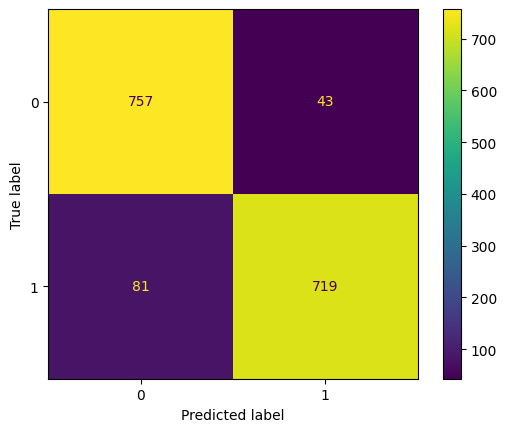

In [39]:
cm = confusion_matrix(grd_truth, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [40]:
import copy
test_model = torch.load("/kaggle/working/best.pt")
test_model = test_model.to(device)

In [41]:
def test_result(model, test_loader, device,name='no_tta_prob.npy'):
    # testing the model by turning model "Eval" mode
    model.eval()
    preds = []
    aprobs = []
    with torch.no_grad():
        for data in test_loader:
            # move-tensors-to-GPU
            data = data.to(device)
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            prob = nn.Softmax(dim=1)
            # applying Softmax to results
            probs = prob(output)
            #aprobs.append(probs.cpu())
            aprobs.append(probs.detach().cpu().numpy())
            preds.extend(torch.argmax(probs, axis=1).tolist())
#             binary_predictions = (probs[:, 1] >= threshold).int()
#             preds.extend(binary_predictions.tolist())
    aprobs = np.array(aprobs)
    np.save(name,aprobs)
    return preds